<a href="https://colab.research.google.com/github/osimon8/GeoguessrGuessr/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!conda install --file requirements.txt

In [1]:
 %matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
#import sklearn.ensemble.RandomForestClassifier as RandomForestClassifier
import pandas as pd
import os 
import sys
import geopandas
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [167]:
#train_data_directory = '/content/drive/MyDrive/CIS 522/50States500'
train_data_directory = '50States500'
test_data_directory = 'test_data'

transform_pipeline = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64))])

dataset = datasets.ImageFolder(train_data_directory, transform_pipeline)
test_dataset = datasets.ImageFolder(test_data_directory, transform_pipeline)
n = len(dataset)
train_size = int(0.8*n)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, n - train_size])
#train_dataset = dataset

#validation_dataset = []

batch_size = 100
batch_size_big = 100

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
data_loader_small = torch.utils.data.DataLoader(dataset, batch_size = 4)
data_loader_shuffled = torch.utils.data.DataLoader(dataset, batch_size = 100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)


In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: 50States500
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [50]:
def get_state_data_loader(state, batch_size=100):
    tot = len(train_dataset)
    c = dataset.class_to_idx [state]
    weights = [1e-4 if i // 500 == c else 0 for i in range(tot)]
    sampler = torch.utils.data.WeightedRandomSampler(weights, batch_size)
    return  torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler=sampler)
    
    

## Data Visualization

### Sample set of images
Here we see the four images for a random coordinate sampled from the dataset. The images appear in the order of camera rotation 0, 90, 180, and 270 degrees.

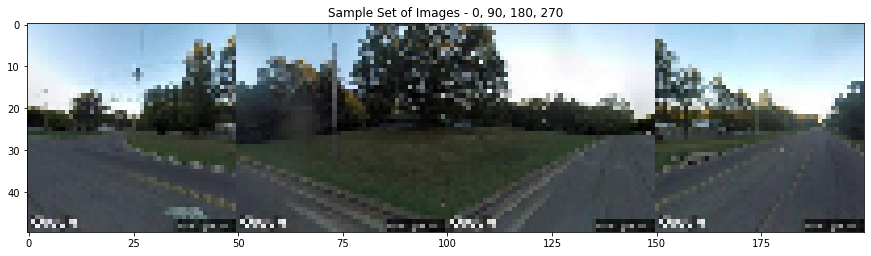

In [43]:
example_batch = next(iter(data_loader_small))[0]
stacked = example_batch[0]
for i in range(1, 4):
    stacked = torch.cat((stacked,example_batch[i]), 2)
    
plt.figure(figsize=(15,10))
plt.title("Sample Set of Images - 0, 90, 180, 270")
plt.imshow(stacked.permute(1, 2, 0))

### Sample image for each state

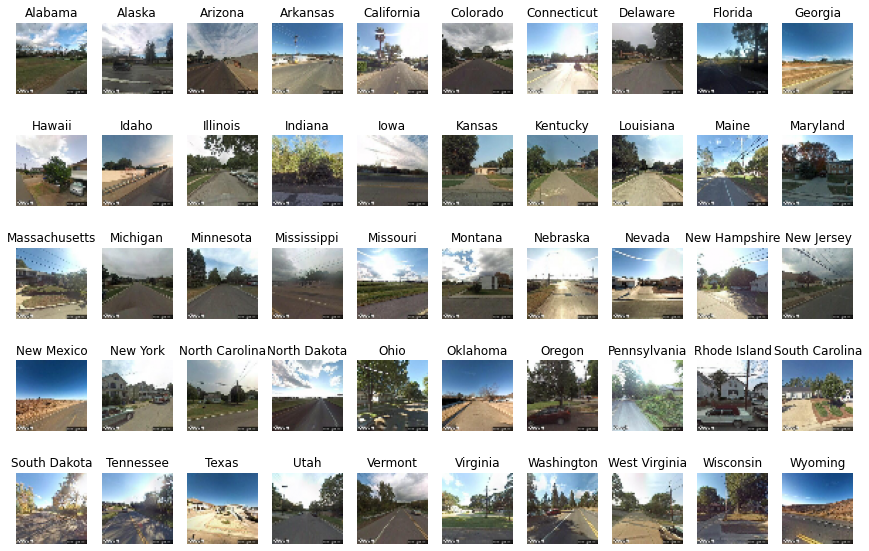

In [45]:
sample_50 = {}
for data, label in data_loader_shuffled:
    for d, l in zip(data, label):
        if l.item() in sample_50.keys():
            continue
        sample_50[l.item()] = d
    if (len(sample_50) == 50):
        break

fig, axs = plt.subplots(5, 10, figsize=(15,10))
for label, im in sorted(sample_50.items()):    
    ax = axs.flat[label] 
    ax.set_title(dataset.classes[label])
    ax.imshow(im.permute(1, 2, 0))
    ax.axis('off')

### Average image and histogram by state 
In this section, we sample some random images for a given state, then average all of those images together and plot a histogram. We can see that for all states we tend towards an image with a gray bottom half and a bluish top half, indicating that our average image looks at the road with the sky above it. Sampling a smaller number of images is a little bit more informative; we can start to make out that more rural states tend to have more trees visible and urban states have more gray color overall.

In [46]:
def collect_state_data(desired_states, num = 10):
    results = {state: [] for state in desired_states }

    for state in desired_states:
        loader = get_state_data_loader(state, batch_size = num)
        for data, _ in loader:
            results[state].extend(data)
            
    return results

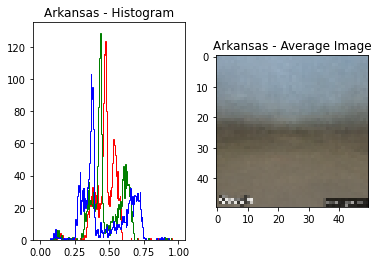

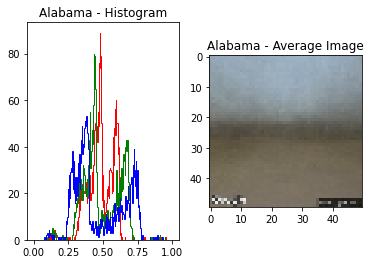

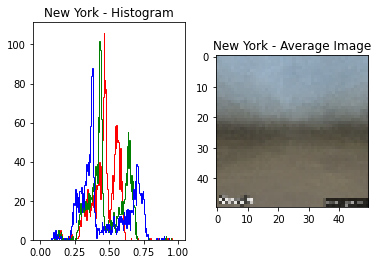

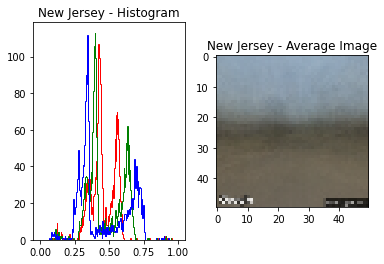

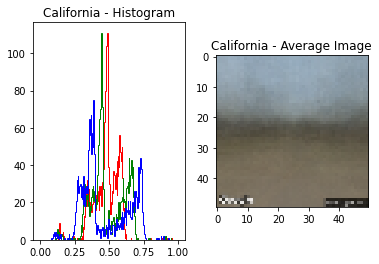

In [52]:
desired_states = ['Arkansas', 'Alabama', 'New York', 'New Jersey', 'California']
num_images = 100

state_data = collect_state_data(desired_states, num=num_images)
means = {}
colors = ['red', 'green', 'blue']

for state in desired_states:
    tens = torch.stack(state_data[state])
    mean = torch.mean(tens, dim=0).permute(1, 2, 0)
    fig = plt.figure()
    plt.axis('off')

    fig.add_subplot(121)
    plt.title('{} - Histogram'.format(state))
    for i in range(3):
        plt.hist(mean.numpy()[:, :, i].ravel(), bins=256, range=(0.0, 1.0), histtype='step', color=colors[i])
    
    fig.add_subplot(122)
    plt.title('{} - Average Image'.format(state))
    plt.imshow(mean)
    
    plt.show()

In [159]:
states = geopandas.read_file('map_data/States_shapefile.shp')
states = states[states['State_Name'] != 'DISTRICT OF COLUMBIA']
states = states.to_crs("EPSG:3395")
states_contig = states[states['State_Name'] != 'HAWAII']
states_contig = states_contig[states_contig['State_Name'] != 'ALASKA']

# us_boundary_map = states_contig.boundary.plot(figsize=(18, 12), color='Black', linewidth=1)
# us_map = states_contig.plot(ax=us_boundary_map, linewidth=4)
# us_map.axis('off')

In [129]:
def get_state_geo(state):
    return states[states['State_Name'] == state]    

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: 50States500
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear)
           )


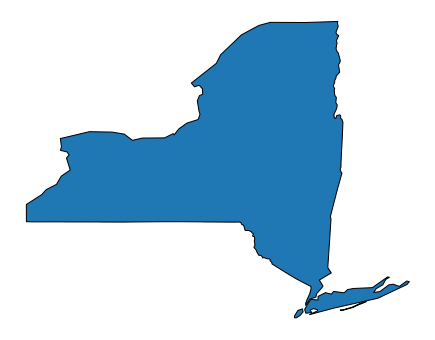

In [130]:
ny = get_state_geo("NEW YORK")
ny_boundary = ny.boundary.plot(figsize=(9, 6), color='Black', linewidth=1)
us_map = ny.plot(ax=ny_boundary, linewidth=4)
us_map.axis('off')
print(dataset)

In [ ]:
dataframe = pd.DataFrame()

ctr = 0

# for data, label in data_loader:
#     num = data.numpy()
#     dataframe.append(num)
#     ctr += 1
#     if (ctr > 1000):
#         break
    #dataframe.insert()


In [ ]:
#print(train_dataset.imgs[:1000])

In [91]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier()

'''randomForest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
'''



"randomForest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n           max_depth=None, max_features='auto', max_leaf_nodes=None,\n           min_impurity_split=1e-07, min_samples_leaf=1,\n           min_samples_split=2, min_weight_fraction_leaf=0.0,\n           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,\n           verbose=0, warm_start=False)\n"

In [89]:
from sklearn.metrics import accuracy_score

rf_data_size = 1000

data_loader_all = torch.utils.data.DataLoader(train_dataset, batch_size = rf_data_size, shuffle=True)
(X,y) = next(iter(data_loader_all))

In [90]:
print(X.shape)
X = X.reshape(rf_data_size, -1)


torch.Size([1000, 3, 64, 64])


In [92]:
randomForest.fit(X,y)

RandomForestClassifier()

In [82]:
from sklearn.metrics import accuracy_score
X_test, y_test = next(iter(test_loader))


In [83]:
X_test = X_test.reshape(100, -1)
preds = randomForest.predict(X_test)
print("Accuracy:", accuracy_score(y_test,preds))

Accuracy: 0.11


In [115]:

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 32, 3, 1)
        self.fc1 = nn.Linear(288, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc_alt_1 = nn.Linear(256, 128)
        self.fc_alt_2 = nn.Linear(128, 50)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        #x = self.conv5(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, 3)
        x = torch.flatten(x, 1)
        x = self.fc_alt_1(x)
        x = F.relu(x)
        x = self.fc_alt_2(x)
       
        return x

In [85]:
def train(model, device, train_loader, validation_loader, epochs):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01, momentum=0.9)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

                # add micro for coding training loop
            optimizer.zero_grad()
            output = model(data)
                
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            #tepoch.set_postfix(loss=loss.item())
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        l = running_loss/len(train_loader)
        train_loss.append(l)
        train_acc.append(correct/total)
        print('Epoch {} Loss: {}'.format(epoch, l))
                
        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
                
            loss = criterion(output, target)
            #tepoch.set_postfix(loss=loss.item())
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
    
    return train_loss, train_acc, validation_loss, validation_acc 



In [86]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [22]:
from tqdm.notebook import tqdm, trange


ModuleNotFoundError: No module named 'tqdm'

In [ ]:
device

device(type='cuda')

Epoch 0 Loss: 3.9134090530872343
Epoch 1 Loss: 3.911993594169617
Epoch 2 Loss: 3.909589068889618
Epoch 3 Loss: 3.881330473423004
Epoch 4 Loss: 3.809379756450653
Epoch 5 Loss: 3.7847614538669587
Epoch 6 Loss: 3.7654020273685456
Epoch 7 Loss: 3.7449951374530794
Epoch 8 Loss: 3.7244764375686645
Epoch 9 Loss: 3.6995689356327057
Epoch 10 Loss: 3.669293247461319
Epoch 11 Loss: 3.634940593242645
Epoch 12 Loss: 3.6101635682582853
Epoch 13 Loss: 3.5743893575668335
Epoch 14 Loss: 3.527801601886749
Epoch 15 Loss: 3.4772361505031584
Epoch 16 Loss: 3.419126065969467
Epoch 17 Loss: 3.3725442683696745
Epoch 18 Loss: 3.3333638381958006
Epoch 19 Loss: 3.289329721927643


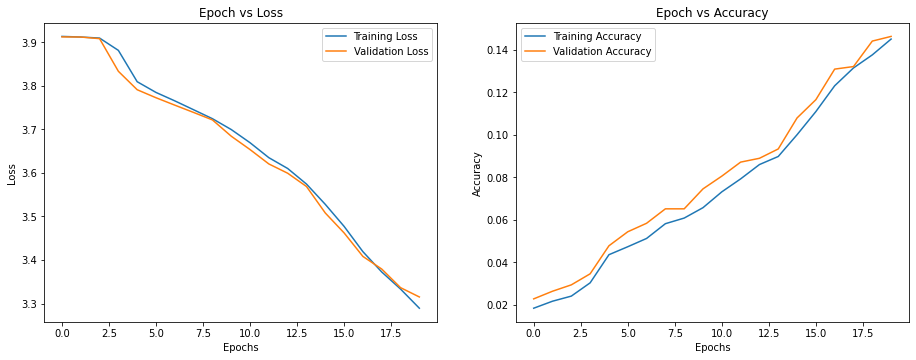

In [116]:
net = Net1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, data_loader, validation_loader, 20)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)


In [240]:
def save_model(model, filename):
    if not os.path.exists('trained_models/'):
        os.mkdir('trained_models/')
    torch.save(model.state_dict(), 'trained_models/' + filename)

#save_model(net, '20e')

In [228]:
def plot_heatmap(probs, true_label):
    ak_index = dataset.class_to_idx["Alaska"]
    hi_index = dataset.class_to_idx["Hawaii"]
    plt.figure(figsize=(18, 12))
    plt.title("Image True Label: {}".format(true_label))
    ax = plt.gca()
    us_boundary_map = states_contig.boundary.plot(ax=ax, color='Black', linewidth=1)
    probs_sliced = []
    for i in range(50):
        if i != hi_index and i != ak_index:
            probs_sliced.append(probs[i])
    us_map = states_contig.plot(column=np.array(probs_sliced) , ax=us_boundary_map, cmap='magma', legend=True, linewidth=4)
    us_map.axis('off')
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    hawaii = get_state_geo('HAWAII')
    hi_boundary_map = hawaii.boundary.plot(figsize=(1, 1), ax=ax1, color='Black', linewidth=1)
    hawaii_map = hawaii.plot(column=np.array([probs[hi_index]]) , ax=hi_boundary_map, cmap='magma', linewidth=4)
    hawaii_map.axis('off')
    alaska = get_state_geo('ALASKA')
    ak_boundary_map = alaska.boundary.plot(figsize=(4, 4), ax=ax2, color='Black', linewidth=1)
    alaska_map = alaska.plot(column=np.array([probs[ak_index]]) , ax=ak_boundary_map, cmap='magma', linewidth=4)
    alaska_map.axis('off')

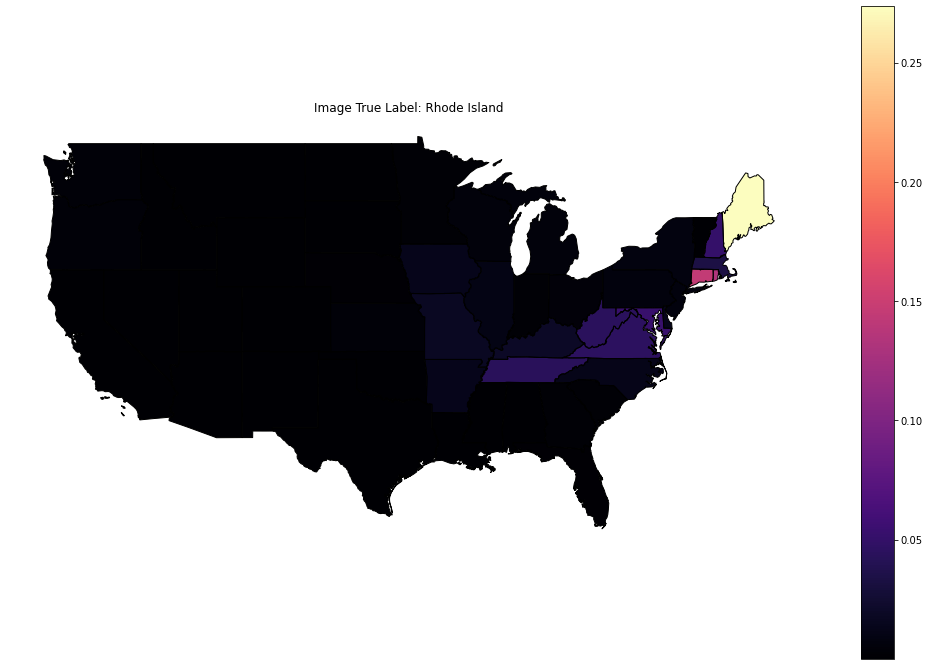

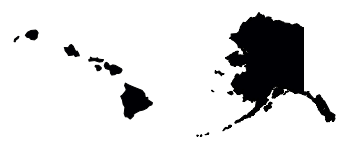

In [236]:
for data, label in test_loader:
    pred = net.forward(data.to(device))
    pred = F.softmax(pred, dim=1)
    #print(pred.shape)
    probs = pred[0].detach().cpu().numpy()
    #print(probs)
    lab = dataset.classes[label[0].item()]
    plot_heatmap(probs, lab)
    break